In [1]:
import math
import os
from skimage.filters import threshold_otsu
import pandas as pd
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import  tqdm
import trackpy as tp

In [15]:
movie = 'e561e1'
DATA_PATH = r'C:\Users\amityu\Gel_Drop_Data'

#MOVIE_PATH = os.path.join(DATA_PATH , 'tif_centered')
#MOVIE_PATH = os.path.join(DATA_PATH, 'eye_gel')
MOVIE_PATH = os.path.join(DATA_PATH, movie)
output_maxima_dir =r'C:\Users\amityu\Gel_Drop_Data\{}_local\\'.format(movie)
#output_maxima_dir =r'C:\Users\amityu\Gel_Drop_Data\175_950_ex1_local\\'

# tiff source
output_dir = r'C:\Users\amityu\Gel_Drop_Data\eye_clip\\'
#output_dir = r'C:\Users\amityu\Gel_Drop_Data\175_950_ex1_clip\\'
output_dir = r'C:\Users\amityu\Gel_Drop_Data\{}_clip\\'.format(movie)

files = os.listdir(os.path.join(MOVIE_PATH, 'tif'))
files= sorted(files)
files = files[:1800] #take only relevant files

In [16]:
# read all images

# apply script only on quater on the image to speed up the code development
only_quarter = False
img_list = []
for file in tqdm(files):
    img = tifffile.imread(os.path.join(MOVIE_PATH, 'tif',file))
    if only_quarter:
        img[img.shape[0]//2:,:] = 0
        img[:, img.shape[1]//2:] = 0

    img_list.append(img)
image_array = np.array(img_list)


  0%|          | 0/1800 [00:00<?, ?it/s]

In [25]:
#clipping for visualization to adjust image contrast
for file in tqdm(files):
    img = tifffile.imread(os.path.join(MOVIE_PATH, 'tif',file))
    data = img.flatten()
    data = data[~np.isnan(data)]
    threshold = threshold_otsu(data)
    threshold_data = data[data > threshold]
    threshold2 = np.percentile(threshold_data, 5)
    img=np.clip(img, threshold2, np.percentile(img, 99))
    tifffile.imwrite(os.path.join(output_dir,file), img)
    


  0%|          | 0/1800 [00:00<?, ?it/s]

In [17]:
import numpy as np
import scipy.ndimage as ndimage

def find_local_maxima(_image, min_distance=1, q_max  = 0.1):
    """
    :param _image: The input image for finding local maxima.
    :param min_distance: The minimum distance between two local maxima. Defaults to 1.
    :param q_max: The threshold value to filter out low-value peaks. Defaults to 0.1.
    :return: A list of coordinates representing the local maxima.

    """
    # Apply a maximum filter to find local maxima
    neighborhood_size = 2 * min_distance + 1
    local_max = ndimage.maximum_filter(_image, size=neighborhood_size, mode='constant')

    # Compare the original image to the local maxima
    local_maxima = (_image == local_max)

    # Apply a threshold to avoid low-value peaks (optional)
    _threshold = np.nanmax(_image) * q_max
    local_maxima = local_maxima & (_image > _threshold)

    # Label the maxima
    labeled, num_objects = ndimage.label(local_maxima)

    # Find the coordinates of the local maxima
    slices = ndimage.find_objects(labeled)
    _coordinates = [(int(s[0].start + s[0].stop - 1) // 2, int(s[1].start + s[1].stop - 1) // 2) for s in slices]
    
    return _coordinates



In [18]:
## creates images with cross at local maxima for tracking in TRACKMATE
## saves coordinates as a list of coordinates for each time in dataframe of lists
x_list = []
y_list = []
frame_list = []
for i,file in tqdm(enumerate(files)):
    coordinates = find_local_maxima(image_array[i],6)
    #img = paint_indices_cross(image_array[i], coordinates)
    x_list+=[x for (y,x) in coordinates]
    y_list+=[y for (y,x) in coordinates]

    frame_list+=[i]*len(coordinates)
    #tifffile.imwrite(os.path.join(output_maxima_dir, file), img)

0it [00:00, ?it/s]

In [19]:

co_df = pd.DataFrame({'frame': frame_list,'y': y_list,'x':x_list})
co_df.to_csv(os.path.join(output_maxima_dir, 'coordinates.csv') )


In [20]:
# save cordinate_df in a format for the tracking gui 
co_df_gui = pd.DataFrame({'FRAME': frame_list,'POSITION_Y': y_list,'POSITION_X':x_list})
co_df_gui.to_csv(os.path.join(output_maxima_dir, 'coordinates_gui.csv') )


In [21]:
def process_tracks_opt(_df, loc_df=None):
    """
    Process tracks in a given DataFrame and return a new DataFrame with collected results.

    :param _df: The DataFrame containing the tracks.
    :param loc_df: Optional DataFrame containing additional location information. The FRAME,x,y of a fixed point in image for registration
    :return: A new DataFrame with the collected results.
    """
    # Group by TRACK_ID
    grouped = _df.groupby('TRACK_ID')

    min_frames = grouped['FRAME'].min()
    max_frames = grouped['FRAME'].max()

    min_frame_idx = grouped['FRAME'].idxmin()

    min_positions_x = _df.loc[min_frame_idx]['POSITION_X'].values
    min_positions_y = _df.loc[min_frame_idx]['POSITION_Y'].values

    max_frame_idx = grouped['FRAME'].idxmax()

    max_positions_x = _df.loc[max_frame_idx]['POSITION_X'].values
    max_positions_y = _df.loc[max_frame_idx]['POSITION_Y'].values

    if loc_df is not None:
        loc_min_frames = loc_df.set_index('FRAME').loc[min_frames].reset_index()
        loc_max_frames = loc_df.set_index('FRAME').loc[max_frames].reset_index()
    else:
        loc_min_frames = pd.DataFrame({'x': 256, 'y': 256}, index=min_frames.index)
        loc_max_frames = pd.DataFrame({'x': 256, 'y': 256}, index=max_frames.index)

    min_angles = np.degrees(np.arctan2(min_positions_y - loc_min_frames['y'],
                                       min_positions_x - loc_min_frames['x']))
    max_angles = np.degrees(np.arctan2(max_positions_y - loc_max_frames['y'],
                                       max_positions_x - loc_max_frames['x']))

    # Create a new DataFrame with the collected results
    _result_df = pd.DataFrame({
        'TRACK_ID': grouped.groups.keys(),
        'MIN_FRAME': min_frames.values,
        'MAX_FRAME': max_frames.values,
        'MIN_POSITION_X': min_positions_x,
        'MIN_POSITION_Y': min_positions_y,
        'MAX_POSITION_X': max_positions_x,
        'MAX_POSITION_Y': max_positions_y,
        'MIN_ANGLE': min_angles.values,
        'MAX_ANGLE': max_angles.values,
        'DURATION': (max_frames - min_frames).values
    })

    return _result_df


In [22]:
import pandas as pd

# Perform linkage between frames

tracks = tp.link(co_df, search_range=6,
                 memory=4)  # where search_range is the maximum distance features can move between frames, and memory is the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle.

# adding stats and saving for gui
# 
trackmate_df = pd.DataFrame({'TRACK_ID':tracks['particle'], 'FRAME': tracks['frame'], 'POSITION_X':tracks['x'], 'POSITION_Y':tracks['y']})
trackmate_df.to_csv(os.path.join(output_maxima_dir,'trackmate.csv'))


Frame 1799: 1473 trajectories present.


In [625]:
print(len(tracks))

541725


In [23]:
trackmate_df = pd.read_csv(os.path.join(output_maxima_dir,'trackmate.csv'))
#loc_df = pd.read_csv(os.path.join(MOVIE_PATH ,'np/loc.csv'))
loc_df= pd.DataFrame({'FRAME':range(len(image_array)), 'x': [256]*len(image_array), 'y':[256]*len(image_array)}) #location of center of the gel

In [24]:

result_df = process_tracks_opt(trackmate_df, loc_df)  # creating statistics
result_df.to_csv(os.path.join(output_maxima_dir,'tracks.csv'))


In [ ]:
image_folder = os.path.join(DATA_PATH , r'images')
csv_file = os.path.join(DATA_PATH, os.path.join(output_maxima_dir,'tracks.csv'))
'''tracking_data = pd.read_csv(csv_file, skiprows=[1,2,3])'''
print()

In [130]:
result_df = pd.read_csv(os.path.join(output_maxima_dir,'tracks.csv'))

In [160]:
loc_df= pd.DataFrame({'FRAME':range(len(image_array)), 'x': [256]*len(image_array), 'y':[256]*len(image_array)})

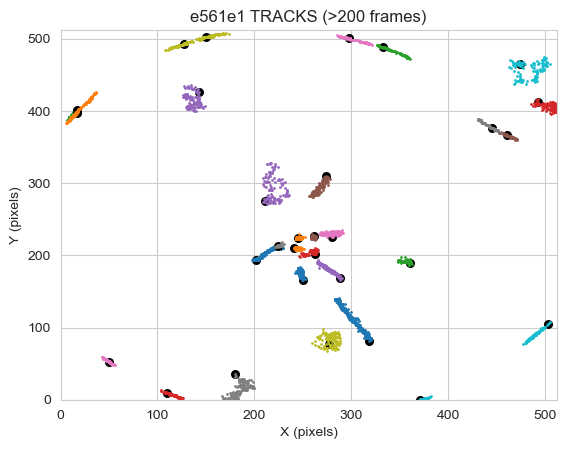

In [16]:

# Plotting the track of particles, compensated for the registration anchor, in loc_df saved in preprocessing file
long_track_id = result_df[result_df['DURATION']>200]['TRACK_ID']
#long_track_id = per_track['TRACK_ID']
#long_track_id = pd.Series(particle_list)
for track_id in long_track_id.iloc[np.random.randint(0,len(long_track_id), size=30)]:
    track_data = trackmate_df[trackmate_df['TRACK_ID'] == track_id]
    x = []
    y = []
    for idx, row in track_data.iterrows():    
        x.append(row['POSITION_X'] - (loc_df.loc[loc_df['FRAME'] == row['FRAME'], 'x']-256).values[0])
        y.append(row['POSITION_Y'] - (loc_df.loc[loc_df['FRAME'] == row['FRAME'], 'y']-256).values[0])
        #x.append(row['POSITION_X'])
        #y.append(row['POSITION_Y'])
    #plt.scatter(result_df[result_df['TRACK_ID'] == track_id]['MIN_POSITION_X'],result_df[result_df['TRACK_ID'] == track_id]['MIN_POSITION_Y'], s=30, c='black')
    x_min = result_df[result_df['TRACK_ID'] == track_id]['MIN_POSITION_X'].values[0]
    x_min -= loc_df.loc[loc_df['FRAME'] == track_data['FRAME'].min(), 'x']-256
    y_min = result_df[result_df['TRACK_ID'] == track_id]['MIN_POSITION_Y'].values[0]
    y_min -= loc_df.loc[loc_df['FRAME'] == track_data['FRAME'].min(), 'y']-256
    #print(x_min, y_min)
    plt.scatter(x_min,y_min, s=30, c='black')

    plt.scatter(x,y, label = str(track_id),s=1 )
plt.title('e561e1 TRACKS (>200 frames)')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.xlim(0, 512)
plt.ylim(0, 512)

#plt.legend()
plt.show()

In [646]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Step 1: Load particle tracks
# Example data: particle_id, time, x, y
data = tracks

# Step 2: Calculate velocities
data['vx'] = data.groupby('particle')['x'].diff() / data.groupby('particle')['frame'].diff()
data['vy'] = data.groupby('particle')['y'].diff() / data.groupby('particle')['frame'].diff()

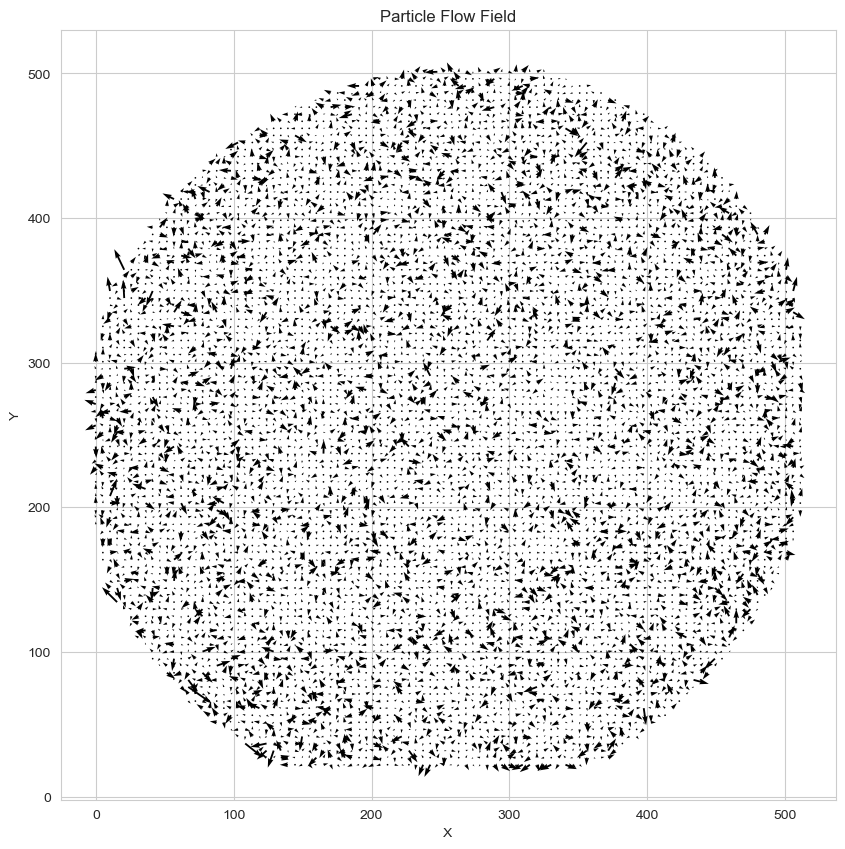

In [271]:
## Experimental
# Drop rows with NaN values (first time step for each particle)
data = data.dropna()

# Step 3: Interpolate velocity field onto a grid
grid_x, grid_y = np.mgrid[data['x'].min():data['x'].max():100j, data['y'].min():data['y'].max():100j]
points = data[['x', 'y']].values
values_vx = data['vx'].values
values_vy = data['vy'].values

grid_vx = griddata(points, values_vx, (grid_x, grid_y), method='cubic')
grid_vy = griddata(points, values_vy, (grid_x, grid_y), method='cubic')

# Step 4: Visualize the flow field
plt.figure(figsize=(10, 10))
plt.quiver(grid_x, grid_y, grid_vx, grid_vy)
plt.title('Particle Flow Field')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [28]:
particle_list = result_df[result_df['DURATION']>15]['TRACK_ID'].unique()
print(len(particle_list))

108895


In [651]:
tracks = tracks[tracks['particle'].isin(particle_list)]
len(tracks)

471034

In [652]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
tracks.sort_values(by = ['particle','frame'], inplace=True)

for particle in tqdm(tracks['particle'].unique()):
    mask = tracks['particle'] == particle
    dx = tracks.loc[mask]['x'].diff()
    tracks.loc[mask,'dx'] = gaussian_filter(dx,3)
    dy = tracks.loc[mask]['y'].diff()
    tracks.loc[mask,'dy'] = gaussian_filter(dy,3)


  0%|          | 0/11741 [00:00<?, ?it/s]

In [547]:
tracks = tracks.dropna()

In [ ]:

# Remove NANs produced by the diff() operation
tracks = tracks.dropna()

# Get the range of 'x' and 'y' over all particles and all frames
x_range = np.min(tracks['x']), np.max(tracks['x'])
y_range = np.min(tracks['y']), np.max(tracks['y'])

# Calculate one 2D velocity field map per frame
for frame in range(1,tracks['frame'].max(),50):# tracks['frame'].unique():
    frame_data = tracks[tracks['frame'] == frame]
    print(frame, len(frame_data))
    if len(frame_data)<4:
        continue
    # Create grid of x and y values
    grid_x, grid_y = np.mgrid[x_range[0]:x_range[1]:50j, y_range[0]:y_range[1]:50j]

    # Perform 2D interpolation
    grid_u = griddata(frame_data[['x', 'y']].values, frame_data['dx'].values, (grid_x, grid_y), method='cubic',
                      fill_value=0)
    grid_v = griddata(frame_data[['x', 'y']].values, frame_data['dy'].values, (grid_x, grid_y), method='cubic',
                      fill_value=0)

    # Plot the velocity field
    plt.figure()
    #plt.quiver(grid_x, grid_y, grid_u, grid_v)
    skip = (slice(None, None, 1), slice(None, None, 1)) 
    plt.quiver( grid_x[skip], grid_y[skip], grid_u[skip], grid_v[skip], scale_units='xy', scale=0.07)
    #plt.quiver(frame_data['y'], frame_data['x'], frame_data['dy'], frame_data['dx'], angles='xy', scale_units='xy', scale=0.010)
    plt.xlim(0, 512)
    plt.ylim(0, 512)    #plt.streamplot(grid_x, grid_y, grid_u, grid_v)
    plt.title('dx field at frame %d' % frame)
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.savefig(os.path.join(DATA_PATH , 'image/eye_15_track{}.png'.format(frame)))
    plt.show()

### <span color = 'red'> thetha calculate from masks

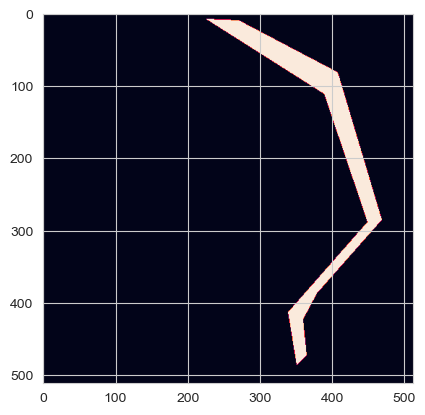

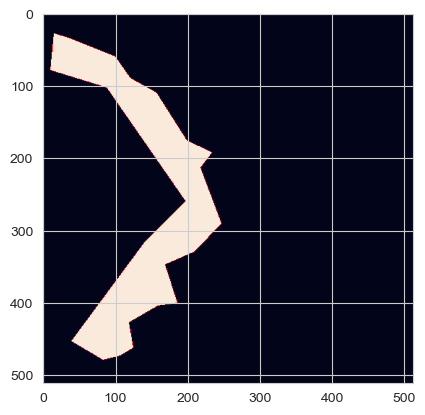

In [81]:
mask1 = tifffile.imread(DATA_PATH +'/masks/eye813mask.tif')
mask2 = tifffile.imread(DATA_PATH +'/masks/eye995mask.tif')
idxy = list(zip(trackmate_df['TRACK_ID'],trackmate_df['POSITION_X'], trackmate_df['POSITION_Y'], trackmate_df['FRAME']))
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

In [29]:
#track_list1 = [(id,x,y) for (id,x,y,f) in idxy if (mask1[y,x]>0) & (f == 98)]
#track_list2 = [(id,x,y) for (id,x,y,f) in idxy if (mask2[y,x]>0) & (f==280)]
# Make sure idxy is sorted by f in ascending order.

#find tracks that starts in mask1 and continues to mask2
def create_matches(idxy, mask, f_min, f_max):
    idxy.sort(key=lambda x: x[3])
    
    # This dictionary will store the tuples
    ids_dict = {}
    
    for item in idxy:
        id, x, y, f = item
        if (mask[y, x] > 0) & (f >= f_min) & (f<=f_max):
            # If tuple with ID is not already in dictionary, or it has a higher 'f', replace it
            if id not in ids_dict or f < ids_dict[id][3]:
                ids_dict[id] = (id, x, y,f)
    
    # Now extract the list of tuples from the dictionary
    return list(ids_dict.values())


Text(0.5, 1.0, 'eye gel')

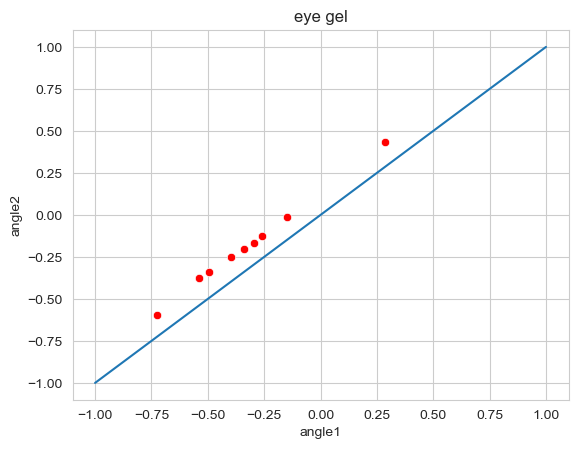

In [83]:
start_index = 715
i1 = 98 
i2 = 260 

track_list1 = create_matches(idxy, mask1, i1,i1+20)
track_list2 = create_matches(idxy, mask2, i2,i2+20)
df1 = pd.DataFrame(track_list1, columns=['id', 'x1', 'y1','f'])
df2 = pd.DataFrame(track_list2, columns=['id', 'x2', 'y2','f'])

# Merge two dataframes on 'id' column
df = pd.merge(df1, df2, on='id')
df[['id']].to_csv(DATA_PATH + '/masks/particle_eye{}_{}_.csv'.format(i1 +start_index,i2+ start_index))

# If you want to reorder the columns to look like id,x1,y1,x2,y2, do the following:
df = df[['id', 'x1', 'y1', 'x2', 'y2']]

df['angle1'] = df.apply(lambda _row: math.atan2((_row['y1']-233),_row['x1']), axis=1)
df['angle2'] = df.apply(lambda _row: math.atan2((_row['y2']-233),_row['x2']), axis=1)



import seaborn as sns
sns.scatterplot(data=df, x = 'angle1', y ='angle2', color='red' )
sns.lineplot(x=[-1,1], y = [-1,1])
plt.title('eye gel')

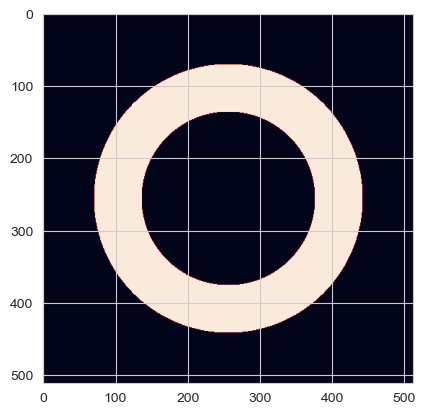

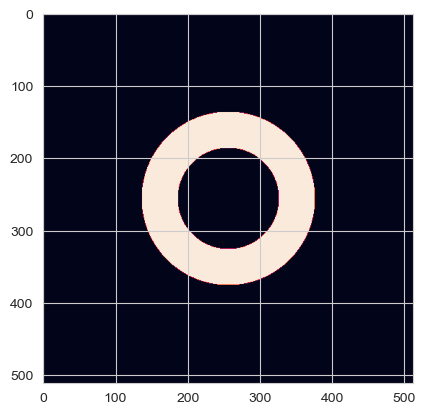

Text(0.5, 1.0, 'dome gel, angle shifted  by -0.35')

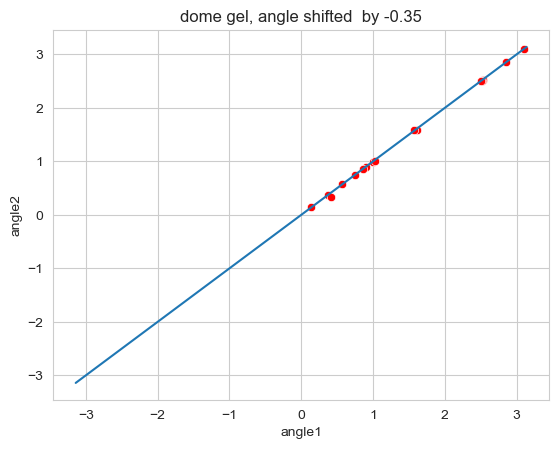

In [67]:


idxy = list(
    zip(trackmate_df['TRACK_ID'], trackmate_df['POSITION_X'], trackmate_df['POSITION_Y'], trackmate_df['FRAME']))

start_index = 175
i1 = 530- start_index
i2 = 743-start_index
#mask1 = tifffile.imread(DATA_PATH + '/masks/dome{}mask.tif'.format(i1 + start_index))
#mask2 = tifffile.imread(DATA_PATH + '/masks/dome{}mask.tif'.format(i2+start_index))
plt.imshow(mask1>0)
plt.show()
plt.imshow(mask2>0)
plt.show()

track_list1 = create_matches(idxy, mask1, i1,i1+20)
track_list2 = create_matches(idxy, mask2, i2,i2+20)
df1 = pd.DataFrame(track_list1, columns=['id', 'x1', 'y1','f'])
df2 = pd.DataFrame(track_list2, columns=['id', 'x2', 'y2','f'])

# Merge two dataframes on 'id' column
df = pd.merge(df1, df2, on='id')
df[['id']].to_csv(DATA_PATH + '/masks/particle_dome{}_{}_.csv'.format(i1 + start_index,i2+ start_index))
# If you want to reorder the columns to look like id,x1,y1,x2,y2, do the following:
df = df[['id', 'x1', 'y1', 'x2', 'y2']]

df['angle1'] = df.apply(lambda _row: (math.atan2((_row['y1'] - 256) , (_row['x1']-256)) -.35)%np.pi, axis=1)
df['angle2'] = df.apply(lambda _row: (math.atan2((_row['y2'] - 256) , (_row['x2']-256))-.35)%np.pi, axis=1)

import seaborn as sns

sns.scatterplot(data=df, x='angle1', y='angle2', color='red')
sns.lineplot(x=[-3.14, 3.14], y=[-3.14, 3.14])
plt.title('dome gel, angle shifted  by -0.35')

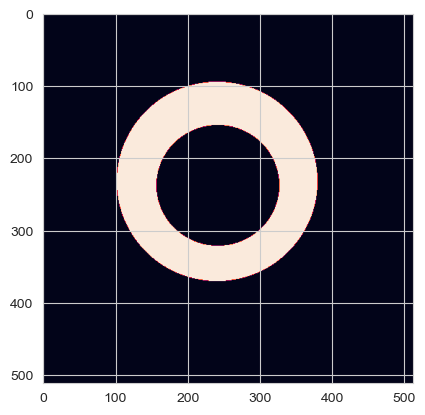

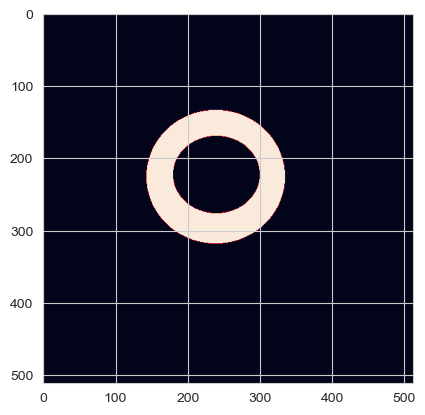

Text(0.5, 1.0, 'dome gel, angle shifted  by -0.35')

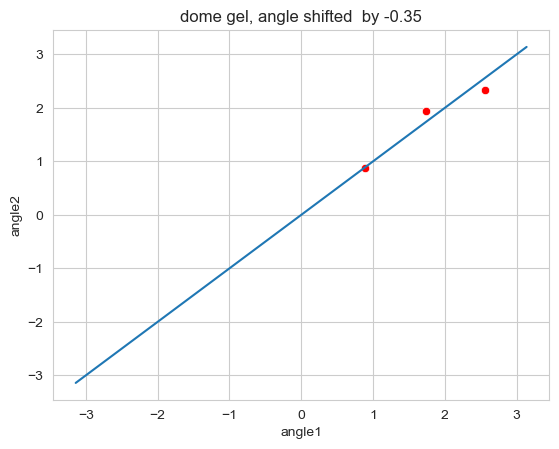

In [33]:
idxy = list(
    zip(trackmate_df['TRACK_ID'], trackmate_df['POSITION_X'], trackmate_df['POSITION_Y'], trackmate_df['FRAME']))

start_index = 0
i1 = 1200- start_index
i2 = 1450-start_index
mask1 = tifffile.imread(DATA_PATH + '/masks/mask_e565e1_{}.tif'.format(i1 + start_index))
mask2 = tifffile.imread(DATA_PATH + '/masks/mask_e565e1_{}.tif'.format(i2+start_index))
plt.imshow(mask1>0)
plt.show()
plt.imshow(mask2>0)
plt.show()

track_list1 = create_matches(idxy, mask1, i1,i1+20)
track_list2 = create_matches(idxy, mask2, i2,i2+20)
df1 = pd.DataFrame(track_list1, columns=['id', 'x1', 'y1','f'])
df2 = pd.DataFrame(track_list2, columns=['id', 'x2', 'y2','f'])

# Merge two dataframes on 'id' column
df = pd.merge(df1, df2, on='id')
df[['id']].to_csv(DATA_PATH + '/masks/particle_565{}_{}_.csv'.format(i1 + start_index,i2+ start_index))
# If you want to reorder the columns to look like id,x1,y1,x2,y2, do the following:
df = df[['id', 'x1', 'y1', 'x2', 'y2']]

df['angle1'] = df.apply(lambda _row: (math.atan2((_row['y1'] - 256) , (_row['x1']-256)) -.35)%np.pi, axis=1)
df['angle2'] = df.apply(lambda _row: (math.atan2((_row['y2'] - 256) , (_row['x2']-256))-.35)%np.pi, axis=1)

import seaborn as sns

sns.scatterplot(data=df, x='angle1', y='angle2', color='red')
sns.lineplot(x=[-3.14, 3.14], y=[-3.14, 3.14])
plt.title('dome gel, angle shifted  by -0.35')

In [20]:
import numpy as np


def create_disc_mask(shape, x0, y0, r1, r2):
    """
    Create a 2D mask for a disc with inner radius 'r1' and outer radius 'r2' centered at (x0, y0)
    """
    # Create a coordinate grid
    y, x = np.ogrid[-y0:shape[0] - y0, -x0:shape[1] - x0]

    # Calculate squared distance from the center
    distance2 = x ** 2 + y ** 2

    # Create the disc mask
    disc_mask = np.logical_and(r1 ** 2 <= distance2, distance2 < r2 ** 2)

    return disc_mask

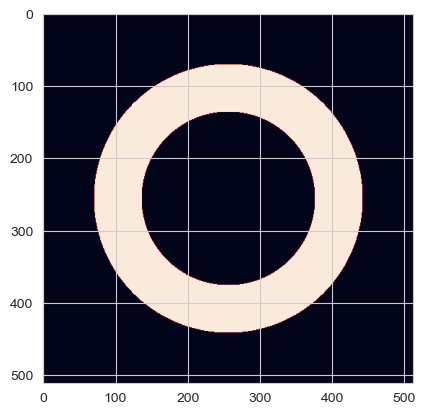

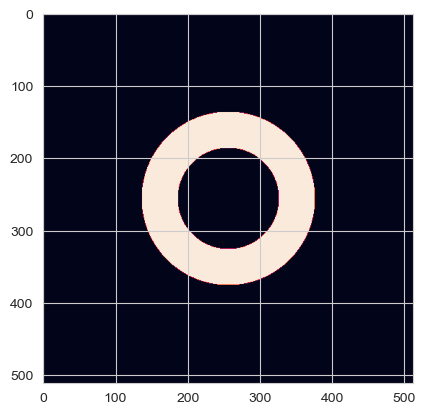

In [21]:
mask1 = create_disc_mask((512,512), 256,256,120,186)
mask2 = create_disc_mask((512,512), 256,256,70,120)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()